<a href="https://drive.google.com/file/d/1-lmvLqHRoVztabnwQ8RbZuDhpsd1kmYY/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIMBRE

**Research project** for the course of *Selected Topics in Music and Acoustic Engineering* :

***Music Instrument Classification***

This project addresses the development of a system for automatic music instrument classification. The dataset
provided is the MedleyDBcollection1, which contains 196 professionally recorded multitrack recordings, including
individual stems corresponding to isolated instruments.
 
Students are tasked with designing a classification pipeline that either recognizes instruments in multitimbral mixtures or classifies individual stems where typically one instrument is active. The project encourages a flexible
approach, allowing exploration of both isolated and polyphonic scenarios.

Key aspects to investigate include:
- Analyzing the robustness of instrument recognition systems when facing different levels of overlapping in
struments within a mixture.
- Studying the relationship between instrumentation and musical genre, as genre annotations are also available in the dataset.
- Exploring the use of co-occurrence matrices to model and understand typical combinations of instruments within different musical contexts.
The students should experiment with feature extraction techniques sensitive to timbral characteristics, such as
spectral descriptors and MFCCs, and assess the effectiveness of classification

### Team:
* Andrea Crisafulli
* Marco Porcella
* Giacomo De Toni
* Gianluigi Vecchini

## *Import libraries*:

In [1]:
# === Core Python & Scientific Computing ===
import numpy as np                # Numerical computing
import pandas as pd              # Data handling and manipulation
import matplotlib.pyplot as plt  # Plotting
from pathlib import Path         # File path handling
import scipy.signal as signal    # Signal processing tools

# === Audio Processing ===
import librosa                   # Audio analysis
import librosa.display           # Visualization for librosa outputs
import IPython.display as ipd    # For audio playback in notebooks

# === Scikit-learn: ML & Preprocessing ===
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay  # Evaluation
from sklearn.decomposition import PCA         # Dimensionality reduction
from sklearn.preprocessing import scale, StandardScaler, MultiLabelBinarizer  # Data scaling & encoding
from sklearn.model_selection import train_test_split  # Dataset splitting
from sklearn.svm import SVC                    # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier  # k-NN classifier
from sklearn.cluster import KMeans            # Clustering

# === Deep Learning: TensorFlow / Keras ===
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint  # Training utilities
from keras.optimizers import Adam            # Optimizer for model training
from keras import layers, models

# === Optional: PyTorch (if used) ===
#import torch
#import torch.nn as nn
#import torch.nn.functional as F              # Functional API for building models

# === Others ===
import yaml                                   # Parsing metadata in YAML format
from collections import Counter               # Frequency counting for label analysis
from tqdm import tqdm                         # Progress bar for loops

# === Plotting Style ===
plt.style.use("seaborn-v0_8")                 # Set default plotting style

### *Import audio data*:

In [2]:
basePath = Path("E:/MedleyDB")                         # For windows
#basePath = Path("/Volumes/Extreme SSD/MedleyDB")        # For mac
audioPath = basePath / "Audio"
data = []

# Iterates over directories in the melodyDB/Audio folder
for songDir in audioPath.iterdir():
    labelArray = []
    
    # Security check to skip not directory items
    if not songDir.is_dir():
        continue
    
    songName = songDir.name
    yamlFilePath = audioPath / songDir / f"{songName}_METADATA.yaml" # Path to YAML metadata file
    
    # Opens YAML metadata file in read mode
    with open(yamlFilePath, "r") as f:
        metadata = yaml.safe_load(f)
    
    # Recovers stems from metadata and stores in dictionary
    stemsData = metadata.get("stems", {})
    
    # Iterates over stems
    for stemId, stem in stemsData.items():
        instrumentData = [] # Empty data for raw paths
        
        rawData = stem.get("raw", {})
        
        # import Raw files 
        # Iterates over raw items to store the relative paths
        #for rawId, raw in rawData.items():
            #rawPath = songDir /  f"{songName}_RAW" / raw.get("filename")
            
            # Checks for valid files
            #if(not rawPath.name.startswith(".")):
            #    newData = {
            #        "song": songName,
            #        "songPath": audioPath / songDir,
            #        "label": stem.get("instrument"),
            #        "filePath": rawPath
            #    }
            #    
            #    data.append(newData)
        
        # Creates new data
        newData = {
            "song": songName,
            "songPath": songDir,
            "label": stem.get("instrument"),
            "filePath": songDir / f"{songName}_STEMS" / stem.get("filename")
        }
        
        # Appends to data 
        data.append(newData)
        
        labelArray.append(stem.get("instrument"))
    
    # Format    
    labelFormatted = "|".join(sorted(set(labelArray)))
    
    mixData = {
        "song": songName,
        "songPath": audioPath / songDir,
        "label": labelFormatted,
        "filePath": songDir / f"{songName}_MIX.wav"
    }
    
    data.append(mixData)
# Create DataFrame
df = pd.DataFrame(data)
print(f"Loaded {len(df)} audio files.")

# String convertion to list
df["labelList"] = df["label"].str.split("|")

mlb = MultiLabelBinarizer()
audioLabelsBinary = mlb.fit_transform(df["labelList"])
audioLabelsBinary = np.asarray(audioLabelsBinary)

Loaded 978 audio files.


In [3]:
df.head()

song                                      songPath  \
0  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   
1  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   
2  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   
3  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   
4  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   

                       label  \
0              electric bass   
1                   drum set   
2  distorted electric guitar   
3  distorted electric guitar   
4      clean electric guitar   

                                            filePath  \
0  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   
1  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   
2  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   
3  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   
4  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   

                     labelList  
0              [electric bass]  
1                   [drum set]  
2  [distorted electric guitar]  
3  [distorted electric guitar]  
4      [clean electric guitar]

In [4]:
df.tail()

song                                 songPath  \
973  TheSoSoGlos_Emergency  E:\MedleyDB\Audio\TheSoSoGlos_Emergency   
974  TheSoSoGlos_Emergency  E:\MedleyDB\Audio\TheSoSoGlos_Emergency   
975       Wolf_DieBekherte       E:\MedleyDB\Audio\Wolf_DieBekherte   
976       Wolf_DieBekherte       E:\MedleyDB\Audio\Wolf_DieBekherte   
977       Wolf_DieBekherte       E:\MedleyDB\Audio\Wolf_DieBekherte   

                                                 label  \
973                                         vibraphone   
974  acoustic guitar|auxiliary percussion|distorted...   
975                                      female singer   
976                                              piano   
977                                female singer|piano   

                                              filePath  \
973  E:\MedleyDB\Audio\TheSoSoGlos_Emergency\TheSoS...   
974  E:\MedleyDB\Audio\TheSoSoGlos_Emergency\TheSoS...   
975  E:\MedleyDB\Audio\Wolf_DieBekherte\Wolf_DieBek...   
976  E:\MedleyDB\Audio\Wolf_DieBekherte\Wolf_DieBek...   
977  E:\MedleyDB\Audio\Wolf_DieBekherte\Wolf_DieBek...   

                                             labelList  
973                                       [vibraphone]  
974  [acoustic guitar, auxiliary percussion, distor...  
975                                    [female singer]  
976                                            [piano]  
977                             [female singer, piano]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song       978 non-null    object
 1   songPath   978 non-null    object
 2   label      978 non-null    object
 3   filePath   978 non-null    object
 4   labelList  978 non-null    object
dtypes: object(5)
memory usage: 38.3+ KB


In [6]:
audioFiles = []
audioLabels = []

# Extract paths and labels
for _, row in df.iterrows():
    audioFiles.append(row["filePath"])
    audioLabels.append(row["labelList"])
    

# Security check
if(len(audioFiles) == len(audioLabels)):
    print(f"Extracted files and labels for a total lenght of {len(audioFiles)}")
else:
    print("Error in dataset")

Extracted files and labels for a total lenght of 978


In [ ]:
# Load data
labelsToLoad = audioLabelsBinary                # REAL DATASET

audioFilesToExtract = audioFiles                # REAL DATASET

signals = []

timeExtraction = 3
samplingRate = 22050
minAmplitude = 0.5

# For now we are extracting only 10 signals
for x in tqdm(audioFilesToExtract, desc="Loading audio files..."):
   y, _ = librosa.load(x, sr=22050)
   
   # Normalization of signal n
   if np.max(np.abs(y)) > 0:
      y = y / np.max(np.abs(y))
      
   # Find the first non-zero sample
   start_index = np.argmax(y > minAmplitude)
   num_samples = int(samplingRate * timeExtraction)
   end_index = start_index + num_samples
   if end_index < len(y):
      y = y[start_index:end_index]
   else:
      y = y[-num_samples:-1]
   
   y = y.astype(np.float16)   
   signals.append(y)

Loading audio files...: 100%|██████████| 978/978 [09:23<00:00,  1.73it/s]


In [19]:
melSpegrams = []

# Iterates over signals, normalizes them and computes mel spectrograms via librosa feature
for signal in tqdm(signals, desc="Processing audio signals..."):

    # Creation of mel spectrogram
    S = librosa.feature.melspectrogram(y=signal, sr=22050)
    S_dB = librosa.power_to_db(S, ref=np.max)
    melSpegrams.append(S_dB)

Processing audio signals...: 100%|██████████| 978/978 [00:06<00:00, 140.34it/s]




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('electric bass',)]


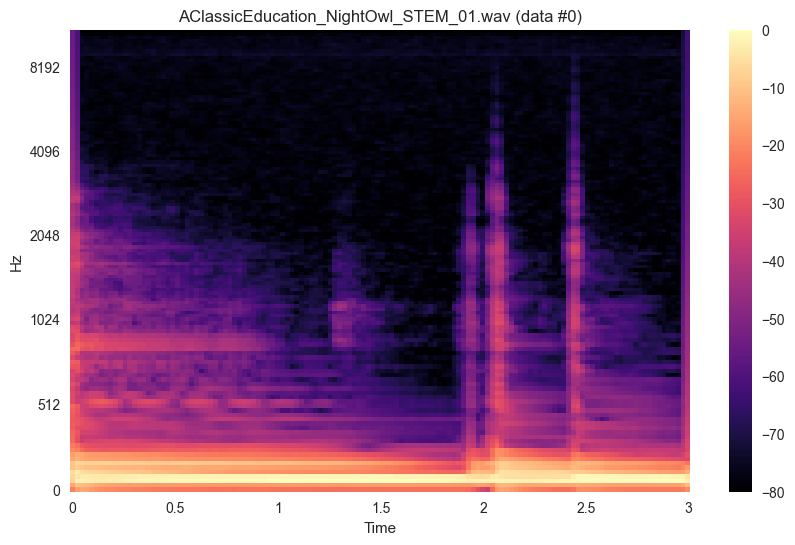



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('acoustic guitar',)]


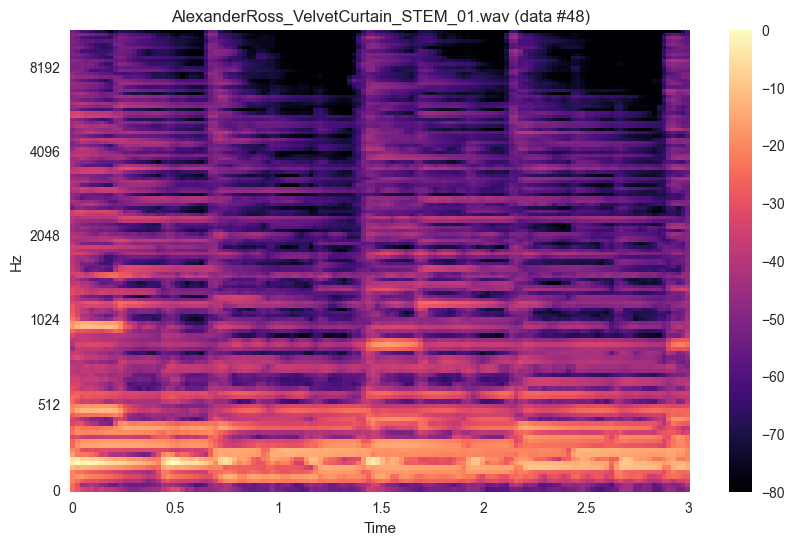



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('piano',)]


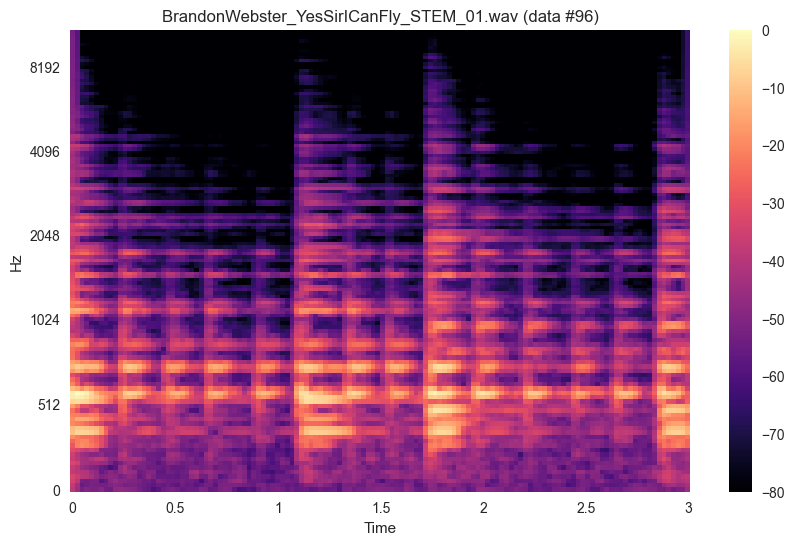



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('female singer',)]


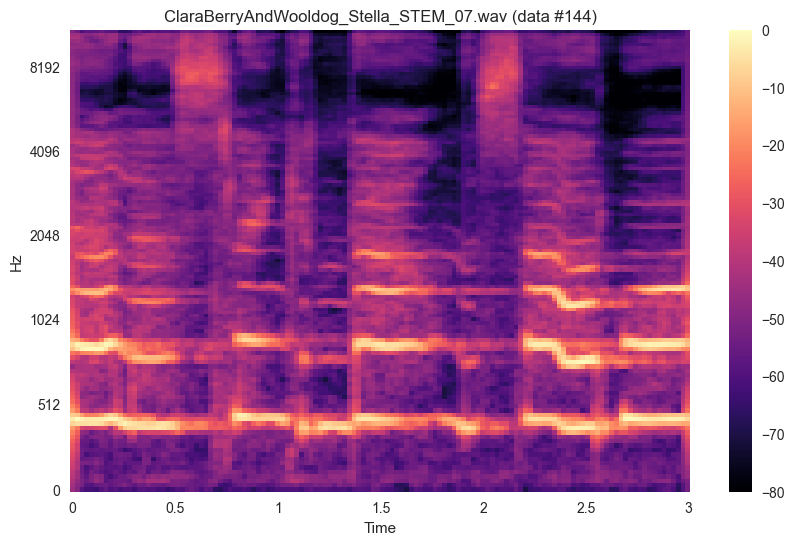



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('fx/processed sound',)]


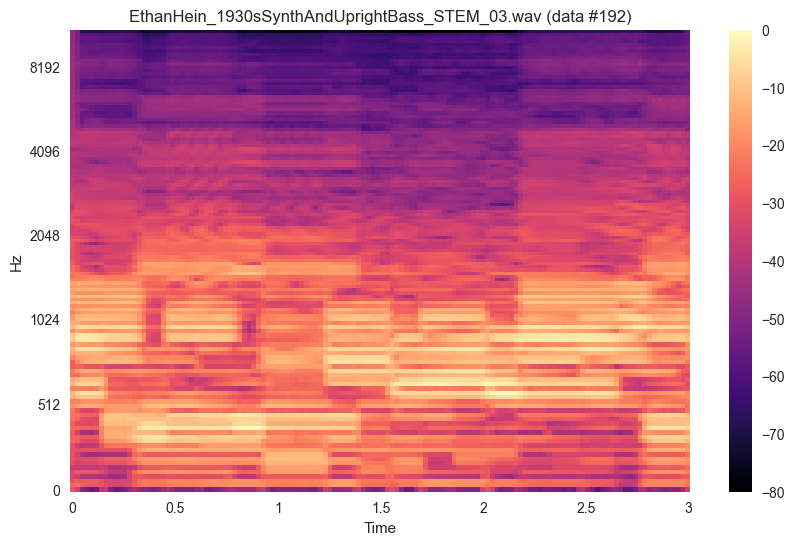



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('male rapper',)]


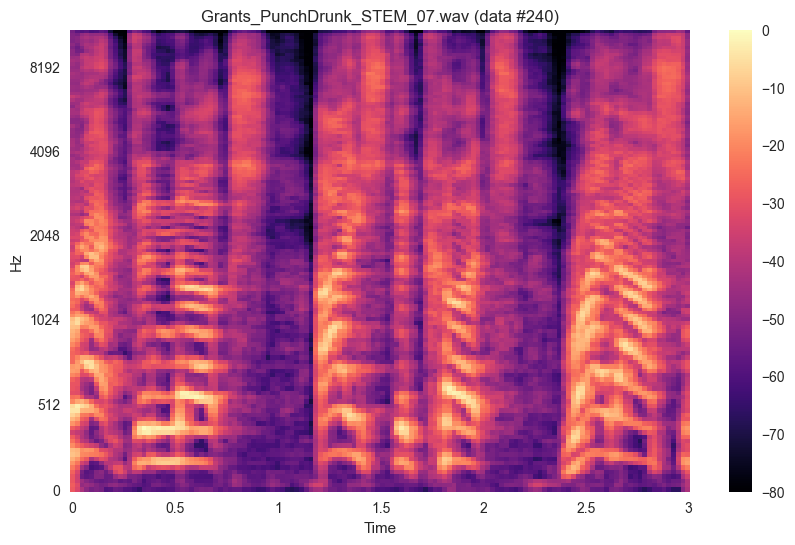



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('vocalists',)]


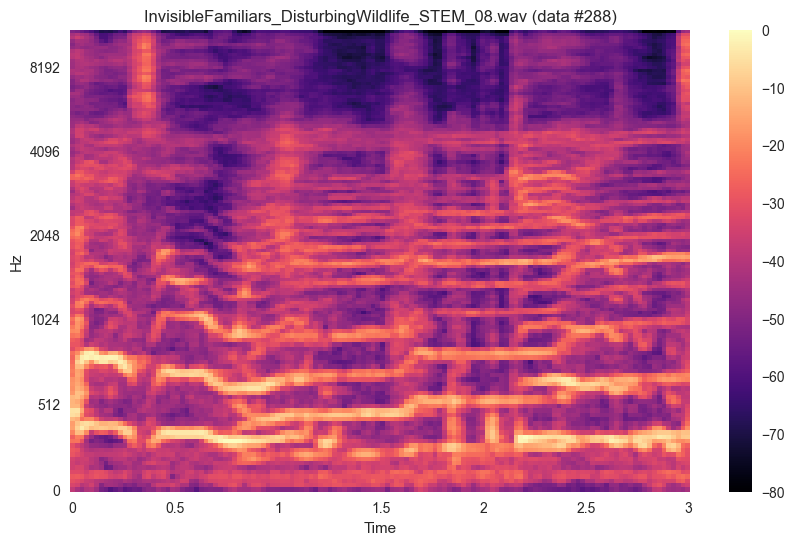



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('oud',)]


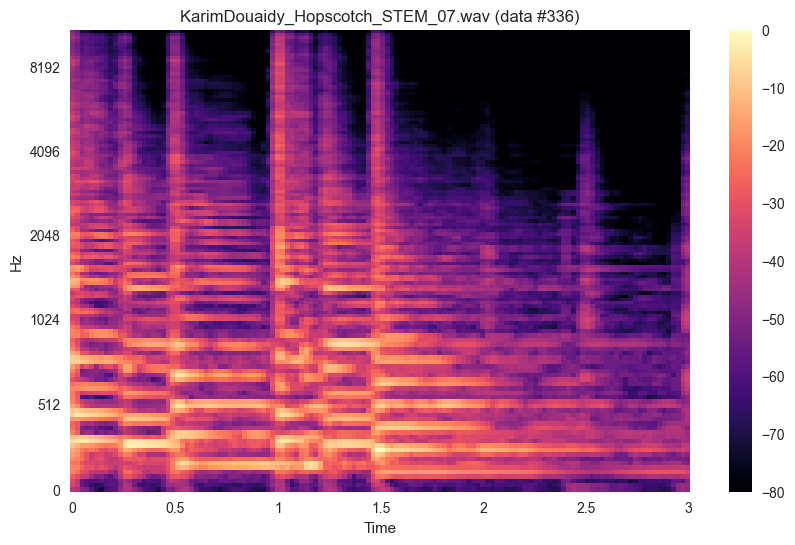



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('scratches',)]


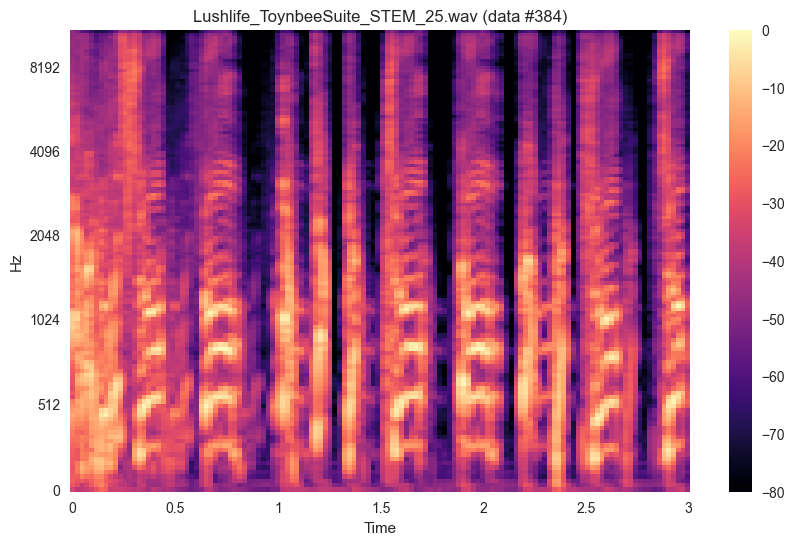



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('piano',)]


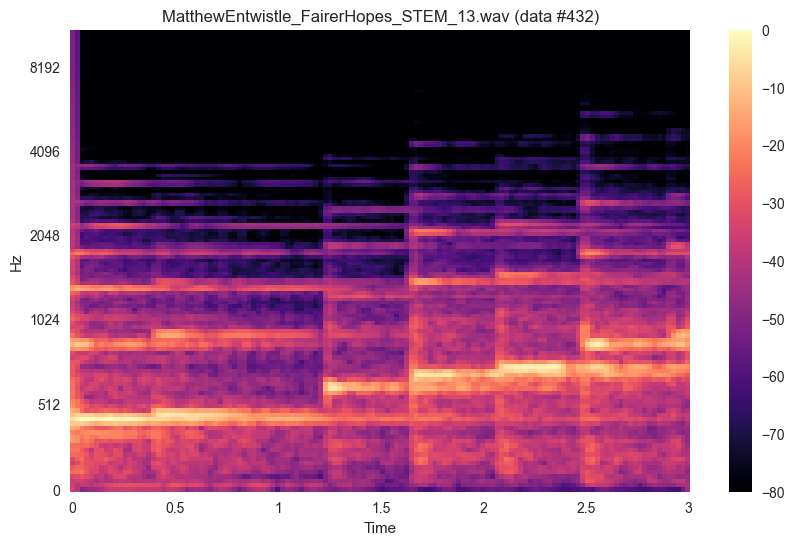



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('distorted electric guitar',)]


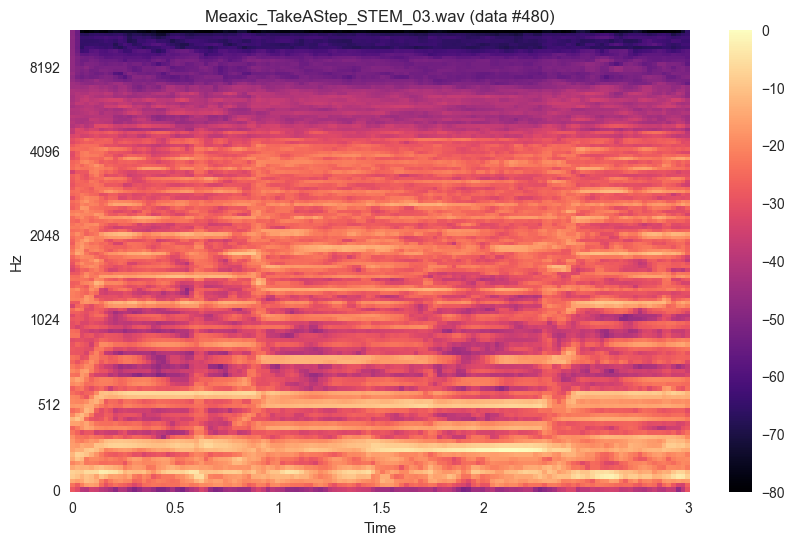



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('double bass',)]


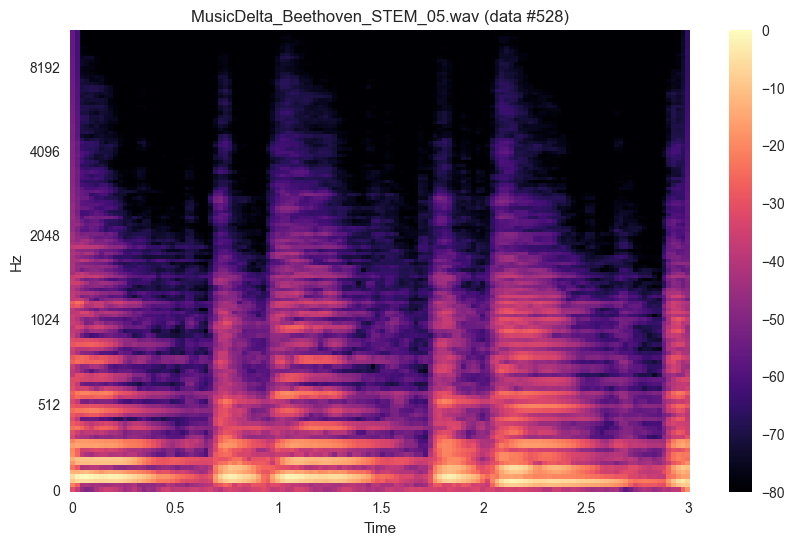



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('gu',)]


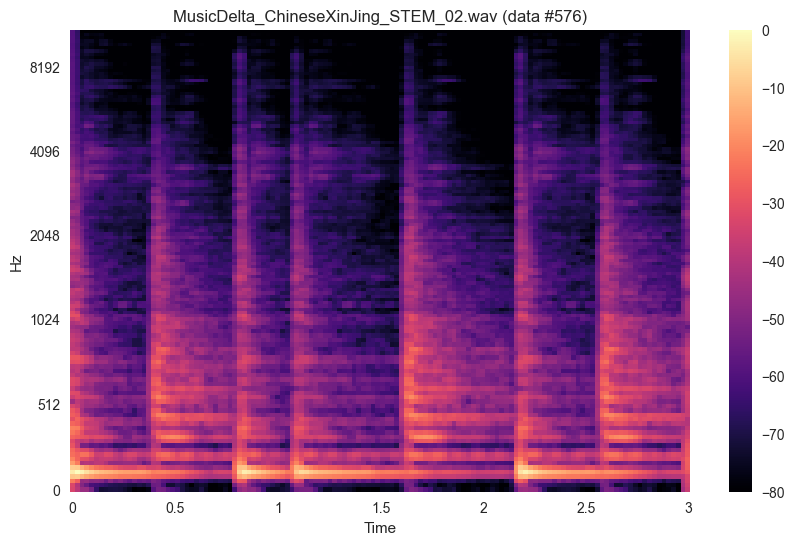



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('trumpet',)]


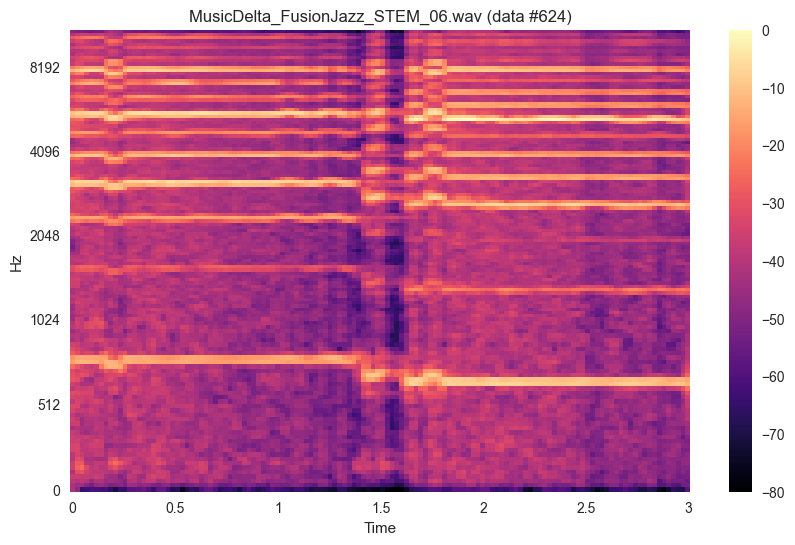



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('clarinet',)]


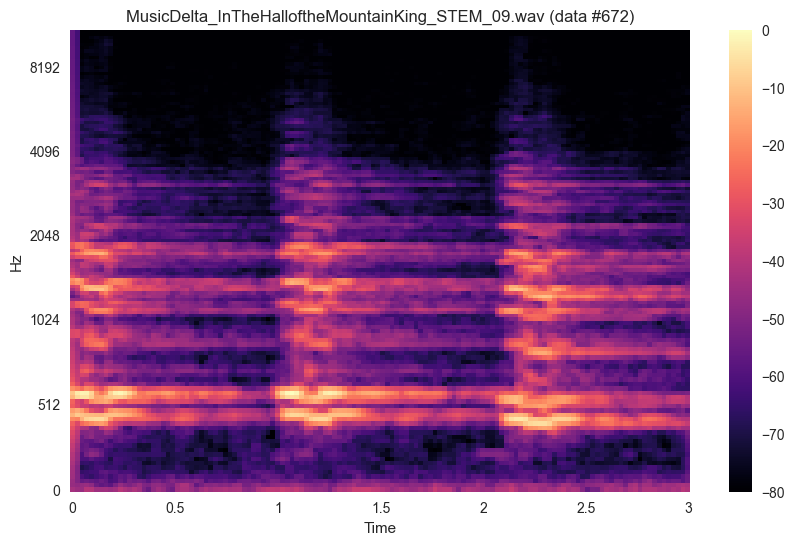



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('clean electric guitar', 'distorted electric guitar', 'drum set', 'electric bass', 'female singer')]


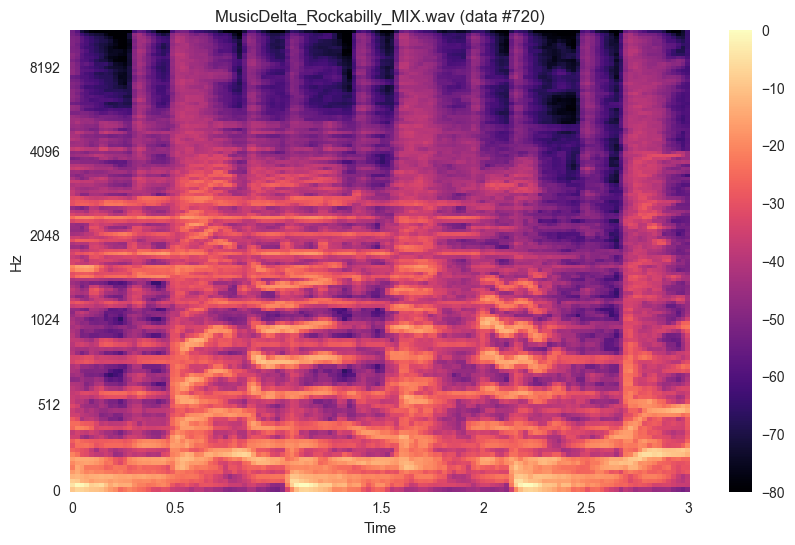



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('Main System',)]


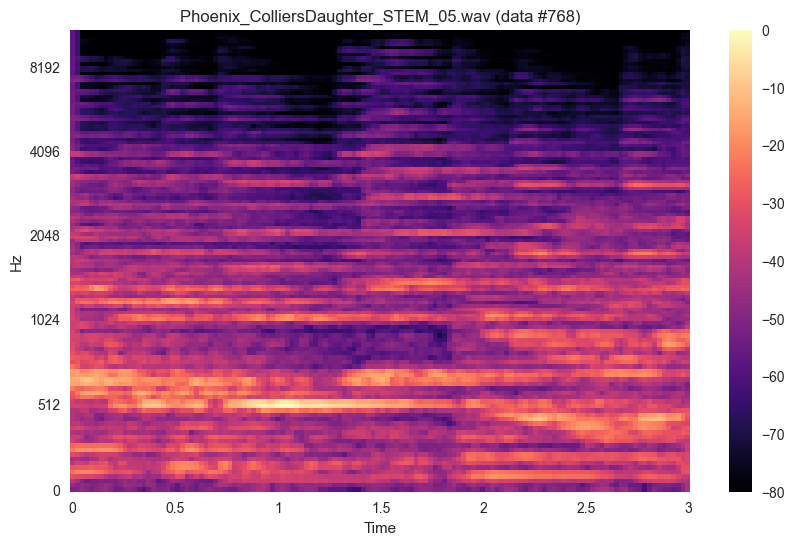



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('electric bass',)]


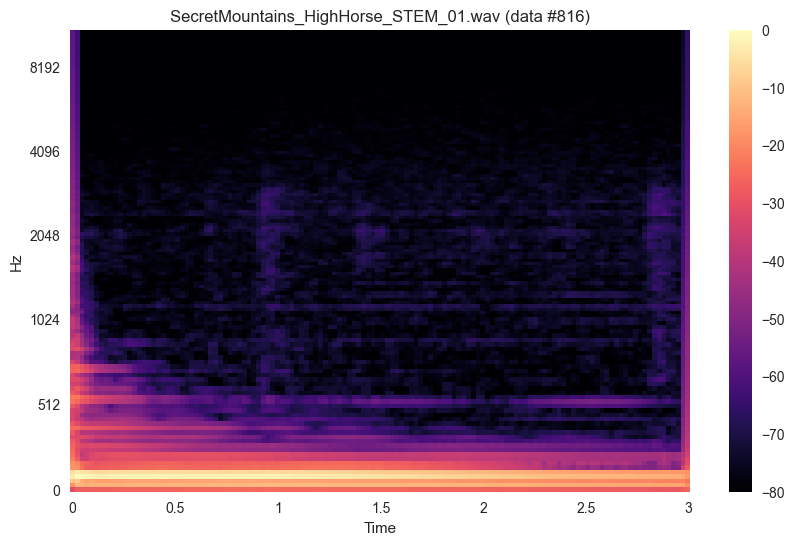



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('drum set',)]


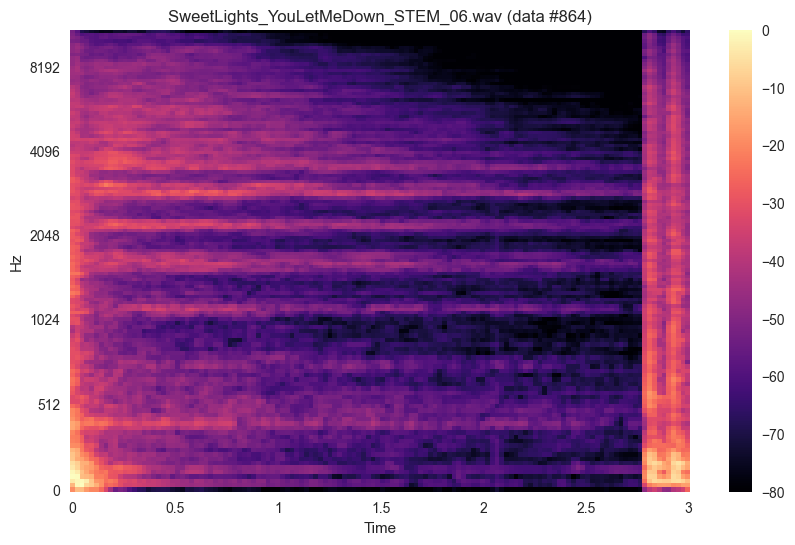



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('tabla',)]


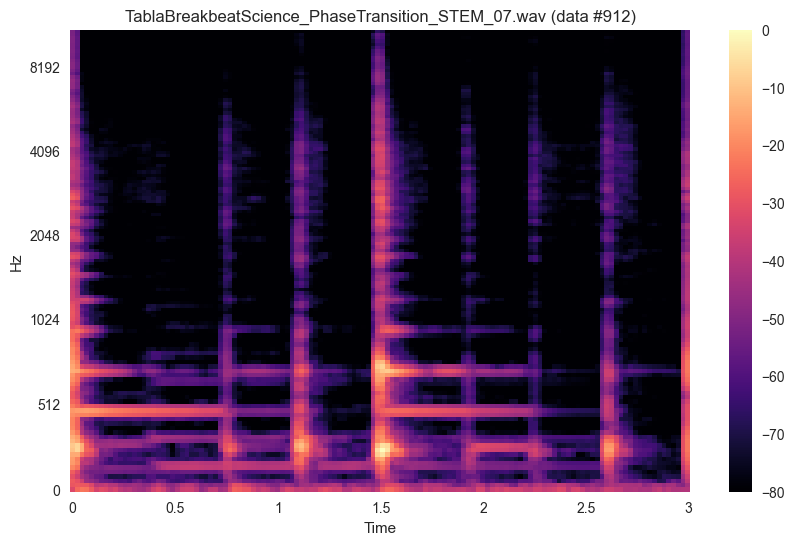



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('fx/processed sound',)]


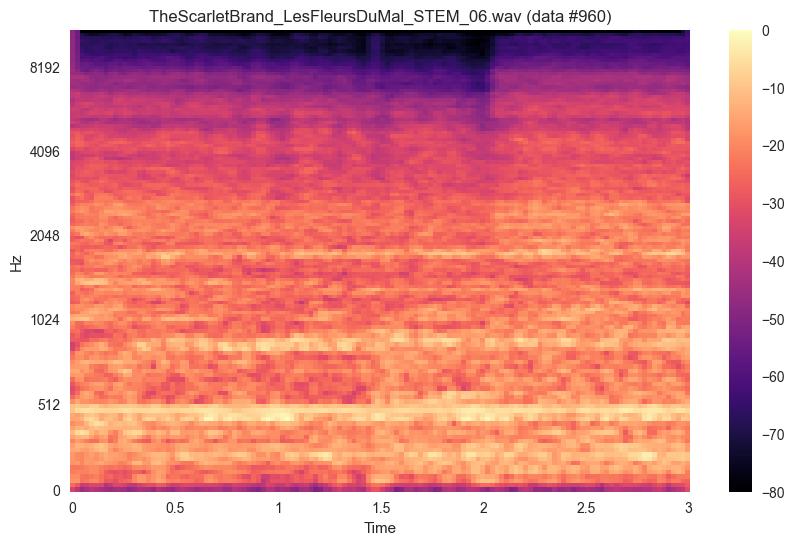

In [23]:
# Plot of spectrograms
import IPython.display

for i in range(0, len(signals), int(len(signals)/20)):
    print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
    
    original_labels = mlb.inverse_transform(np.array([audioLabelsBinary[i]]))
    print("Labels:", original_labels)

    IPython.display.display(IPython.display.Audio(signals[i], rate=22050))

    plt.figure(figsize=(10,6))
    librosa.display.specshow(melSpegrams[i], sr=22050, x_axis='time', y_axis='mel', fmax=22050/2)
    plt.clim(-80,None)
    plt.colorbar()

    filename = str(audioFiles[i]).split("\\")[-1]
    
    plt.title(f'{filename} (data #{i})')
    plt.show()

The user now has to choose which data he wants to load

In [24]:
melSpegrams = np.asarray(melSpegrams)
labelsToLoad = np.asarray(labelsToLoad)

In [ ]:
# Split into Train (70%) and Temp (30%)
# X = mel spectrograms
# y = label
X_train, X_temp, y_train, y_temp = train_test_split(
    melSpegrams, labelsToLoad, test_size=0.30, random_state=1234 ##### 1234
)

# Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Summary
print(f"Train samples:      {len(X_train)}")
print(f"Train lables:       {len(y_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Validation lables: {len(y_val)}")
print(f"Test samples:       {len(X_test)}")
print(f"Test lables:       {len(y_test)}")

Train samples:      684
Validation samples: 147
Test samples:       147
Test lables:       684
Validation lables: 147
Test lables:       147


In [56]:
# === Define input shape and number of output classes ===
inputShape = (128, melSpegrams[0].shape[1], 1)  # (n_mels, time_frames, channels)
numClasses = labelsToLoad.shape[1]              # number of multilabel classes

# === Build CNN model ===
modelCNN = models.Sequential([

    # Input
    layers.Input(shape=inputShape),

    # === Block 1 ===
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    # === Block 2 ===
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    # === Block 3 ===
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    # === Block 4 ===
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    # === Fully Connected ===
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),

    # === Output Layer (sigmoid for multilabel) ===
    layers.Dense(numClasses, activation='sigmoid')
])

# === Compile the model ===
from keras.metrics import BinaryAccuracy, AUC
modelCNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='binary_accuracy'), AUC(multi_label=True, name='auc')]
)

# === Summary ===
modelCNN.summary()

# Optional: show classes
print(f"Number of classes: {numClasses}")
print(f"Class names: {mlb.classes_}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 130, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 43, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 43, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 43, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 43, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 43, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,520,818 (5.80 MB)

 Trainable params: 1,519,858 (5.80 MB)

 Non-trainable params: 960 (3.75 KB)

Number of classes: 82
Class names: ['Main System' 'accordion' 'acoustic guitar' 'alto saxophone'
 'auxiliary percussion' 'bamboo flute' 'banjo' 'baritone saxophone'
 'bass clarinet' 'bass drum' 'bassoon' 'bongo' 'brass section' 'cello'
 'cello section' 'chimes' 'claps' 'clarinet' 'clarinet section'
 'clean electric guitar' 'cymbal' 'darbuka' 'distorted electric guitar'
 'dizi' 'double bass' 'doumbek' 'drum machine' 'drum set' 'electric bass'
 'electric piano' 'erhu' 'female singer' 'flute' 'flute section'
 'french horn' 'french horn section' 'fx/processed sound' 'glockenspiel'
 'gong' 'gu' 'guzheng' 'harmonica' 'harp' 'horn section' 'kick drum'
 'lap steel guitar' 'liuqin' 'male rapper' 'male singer' 'male speaker'
 'mandolin' 'melodica' 'oboe' 'oud' 'piano' 'piccolo' 'sampler'
 'scratches' 'shaker' 'snare drum' 'soprano saxophone' 'string section'
 'synthesizer' 'tabla' 'tack piano' 'tambourine' 'tenor saxophone'
 'timpani' 'toms' 'trombone' 'trombone section' 'trumpet'
 'trumpet sect

In [ ]:


earlyStop = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=100,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=checkpointPath,
    monitor='val_binary_accuracy',
    save_best_only=True,
    verbose=1
)


# Bundle them
callbacks = [csvLogger, earlyStop, checkpoint]

In [57]:
# Path to save logs and models
csvLogPath = 'training_log.csv'
checkpointPath = 'best_model.h5'

# CSVLogger: logs every epoch to CSV
csvLogger = CSVLogger(csvLogPath, append=True)

# EarlyStopping: stop if val_loss doesn't improve after 100 epochs
earlyStop = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=100,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint: save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    filepath=checkpointPath,
    monitor='val_binary_accuracy',
    save_best_only=True,
    verbose=1
)

# Bundle them
callbacks = [csvLogger, earlyStop, checkpoint]

In [58]:
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
modelCNN.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='binary_accuracy'), AUC(multi_label=True, name='auc')]
)

batchSize=32
epochs=300

history = modelCNN.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batchSize, epochs=epochs, verbose=0, callbacks = callbacks)



Epoch 1: val_accuracy improved from -inf to 0.07483, saving model to best_model.h5



Epoch 2: val_accuracy did not improve from 0.07483

Epoch 3: val_accuracy did not improve from 0.07483

Epoch 4: val_accuracy improved from 0.07483 to 0.08844, saving model to best_model.h5



Epoch 5: val_accuracy improved from 0.08844 to 0.20408, saving model to best_model.h5



Epoch 6: val_accuracy did not improve from 0.20408

Epoch 7: val_accuracy did not improve from 0.20408

Epoch 8: val_accuracy did not improve from 0.20408

Epoch 9: val_accuracy did not improve from 0.20408

Epoch 10: val_accuracy did not improve from 0.20408

Epoch 11: val_accuracy did not improve from 0.20408

Epoch 12: val_accuracy did not improve from 0.20408

Epoch 13: val_accuracy improved from 0.20408 to 0.22449, saving model to best_model.h5



Epoch 14: val_accuracy did not improve from 0.22449

Epoch 15: val_accuracy improved from 0.22449 to 0.27211, saving model to best_model.h5



Epoch 16: val_accuracy did not improve from 0.27211

Epoch 17: val_accuracy did not improve from 0.27211

Epoch 18: val_accuracy did not improve from 0.27211

Epoch 19: val_accuracy did not improve from 0.27211

Epoch 20: val_accuracy improved from 0.27211 to 0.29252, saving model to best_model.h5



Epoch 21: val_accuracy did not improve from 0.29252

Epoch 22: val_accuracy did not improve from 0.29252

Epoch 23: val_accuracy improved from 0.29252 to 0.29932, saving model to best_model.h5



Epoch 24: val_accuracy improved from 0.29932 to 0.30612, saving model to best_model.h5



Epoch 25: val_accuracy improved from 0.30612 to 0.31973, saving model to best_model.h5



Epoch 26: val_accuracy improved from 0.31973 to 0.32653, saving model to best_model.h5



Epoch 27: val_accuracy improved from 0.32653 to 0.33333, saving model to best_model.h5



Epoch 28: val_accuracy improved from 0.33333 to 0.39456, saving model to best_model.h5



Epoch 29: val_accuracy did not improve from 0.39456

Epoch 30: val_accuracy did not improve from 0.39456

Epoch 31: val_accuracy did not improve from 0.39456

Epoch 32: val_accuracy did not improve from 0.39456

Epoch 33: val_accuracy did not improve from 0.39456

Epoch 34: val_accuracy did not improve from 0.39456

Epoch 35: val_accuracy did not improve from 0.39456

Epoch 36: val_accuracy did not improve from 0.39456

Epoch 37: val_accuracy did not improve from 0.39456

Epoch 38: val_accuracy did not improve from 0.39456

Epoch 39: val_accuracy did not improve from 0.39456

Epoch 40: val_accuracy did not improve from 0.39456

Epoch 41: val_accuracy did not improve from 0.39456

Epoch 42: val_accuracy did not improve from 0.39456

Epoch 43: val_accuracy did not improve from 0.39456

Epoch 44: val_accuracy did not improve from 0.39456

Epoch 45: val_accuracy did not improve from 0.39456

Epoch 46: val_accuracy did not improve from 0.39456

Epoch 47: val_accuracy did not improve from 0


Epoch 52: val_accuracy did not improve from 0.45578

Epoch 53: val_accuracy did not improve from 0.45578

Epoch 54: val_accuracy did not improve from 0.45578

Epoch 55: val_accuracy did not improve from 0.45578

Epoch 56: val_accuracy did not improve from 0.45578

Epoch 57: val_accuracy did not improve from 0.45578

Epoch 58: val_accuracy did not improve from 0.45578

Epoch 59: val_accuracy did not improve from 0.45578

Epoch 60: val_accuracy did not improve from 0.45578

Epoch 61: val_accuracy did not improve from 0.45578

Epoch 62: val_accuracy did not improve from 0.45578

Epoch 63: val_accuracy did not improve from 0.45578

Epoch 64: val_accuracy did not improve from 0.45578

Epoch 65: val_accuracy did not improve from 0.45578

Epoch 66: val_accuracy did not improve from 0.45578

Epoch 67: val_accuracy did not improve from 0.45578

Epoch 68: val_accuracy did not improve from 0.45578

Epoch 69: val_accuracy did not improve from 0.45578

Epoch 70: val_accuracy did not improve from 0


Epoch 75: val_accuracy did not improve from 0.46939

Epoch 76: val_accuracy did not improve from 0.46939

Epoch 77: val_accuracy did not improve from 0.46939

Epoch 78: val_accuracy did not improve from 0.46939

Epoch 79: val_accuracy did not improve from 0.46939

Epoch 80: val_accuracy did not improve from 0.46939

Epoch 81: val_accuracy did not improve from 0.46939

Epoch 82: val_accuracy did not improve from 0.46939

Epoch 83: val_accuracy did not improve from 0.46939

Epoch 84: val_accuracy did not improve from 0.46939

Epoch 85: val_accuracy did not improve from 0.46939

Epoch 86: val_accuracy did not improve from 0.46939

Epoch 87: val_accuracy did not improve from 0.46939

Epoch 88: val_accuracy did not improve from 0.46939

Epoch 89: val_accuracy did not improve from 0.46939

Epoch 90: val_accuracy did not improve from 0.46939

Epoch 91: val_accuracy did not improve from 0.46939

Epoch 92: val_accuracy did not improve from 0.46939

Epoch 93: val_accuracy did not improve from 0


Epoch 110: val_accuracy did not improve from 0.48980

Epoch 111: val_accuracy did not improve from 0.48980

Epoch 112: val_accuracy did not improve from 0.48980

Epoch 113: val_accuracy did not improve from 0.48980

Epoch 114: val_accuracy did not improve from 0.48980

Epoch 115: val_accuracy did not improve from 0.48980

Epoch 116: val_accuracy did not improve from 0.48980

Epoch 117: val_accuracy did not improve from 0.48980

Epoch 118: val_accuracy did not improve from 0.48980

Epoch 119: val_accuracy did not improve from 0.48980

Epoch 120: val_accuracy did not improve from 0.48980

Epoch 121: val_accuracy did not improve from 0.48980

Epoch 122: val_accuracy did not improve from 0.48980

Epoch 123: val_accuracy did not improve from 0.48980

Epoch 124: val_accuracy did not improve from 0.48980

Epoch 125: val_accuracy did not improve from 0.48980

Epoch 126: val_accuracy did not improve from 0.48980

Epoch 127: val_accuracy did not improve from 0.48980

Epoch 128: val_accuracy did


Epoch 206: val_accuracy did not improve from 0.49660

Epoch 207: val_accuracy did not improve from 0.49660

Epoch 208: val_accuracy did not improve from 0.49660

Epoch 209: val_accuracy did not improve from 0.49660

Epoch 210: val_accuracy did not improve from 0.49660

Epoch 211: val_accuracy did not improve from 0.49660

Epoch 212: val_accuracy did not improve from 0.49660

Epoch 213: val_accuracy did not improve from 0.49660

Epoch 214: val_accuracy did not improve from 0.49660

Epoch 215: val_accuracy did not improve from 0.49660

Epoch 216: val_accuracy did not improve from 0.49660

Epoch 217: val_accuracy did not improve from 0.49660

Epoch 218: val_accuracy did not improve from 0.49660

Epoch 219: val_accuracy did not improve from 0.49660

Epoch 220: val_accuracy did not improve from 0.49660

Epoch 221: val_accuracy did not improve from 0.49660

Epoch 222: val_accuracy did not improve from 0.49660

Epoch 223: val_accuracy did not improve from 0.49660

Epoch 224: val_accuracy did

Best validation accuracy:  0.49659863114356995


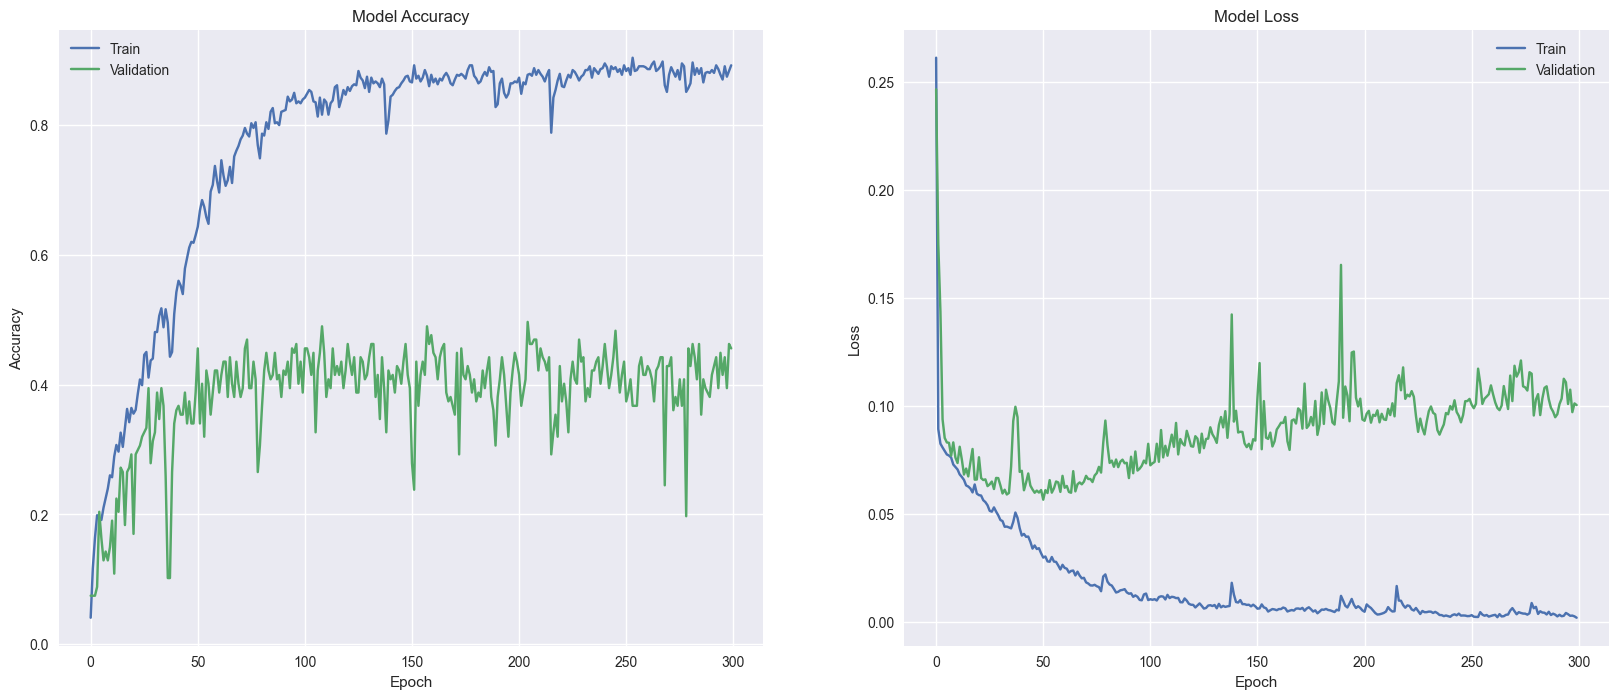

In [59]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
#plt.ylim(0, 1)


plt.subplot(1,2,2)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
#plt.ylim(0, 2);

#best validation accuracy
bestValAccuracy = np.max(history.history['val_accuracy'])
print('Best validation accuracy: ', bestValAccuracy)

In [60]:
testLoss, testAccuracy = modelCNN.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {testAccuracy:.4f}")

Test Accuracy: 0.4354


In [61]:
modelCNN.load_weights('best_model.h5', by_name=False)

[loss_test, acc_test] = modelCNN.evaluate(X_test, y_test)
print('Test Loss: {} \nTest Accuracy: {}'.format(loss_test, acc_test))

[loss_val, acc_val] = modelCNN.evaluate(X_val, y_val)
print('Val Loss: {} \nVal Accuracy: {}'.format(loss_val, acc_val))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.3904 - loss: 0.1399
Test Loss: 0.13408419489860535 
Test Accuracy: 0.4353741407394409
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5045 - loss: 0.0975
Val Loss: 0.09599532932043076 
Val Accuracy: 0.49659863114356995


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_val_pred = modelCNN.predict(X_val).argmax(axis=1)
y_test_pred = modelCNN.predict(X_test).argmax(axis=1)
print(y_test_pred)
# Confusion matrix - validation
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.show()

# Confusion matrix - test
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
[ 12  70  37 116  39  20   9  36 144  28  20   5  36  97  95 117  57  52
 141  86   6   2  56  78  74  79  51 143  30  32  76  68  46  73  17  20
 108 131 101 104  78   8  58   9  93  42  98  84 103 136  93 117 120   2
  22  99 144  35 117 123  63 118  64 130  51 110  21  58   1  17 137  98
 120 101 139  85  83  47 116  48  78  78]


ValueError: Found input variables with inconsistent numbers of samples: [147, 82]

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


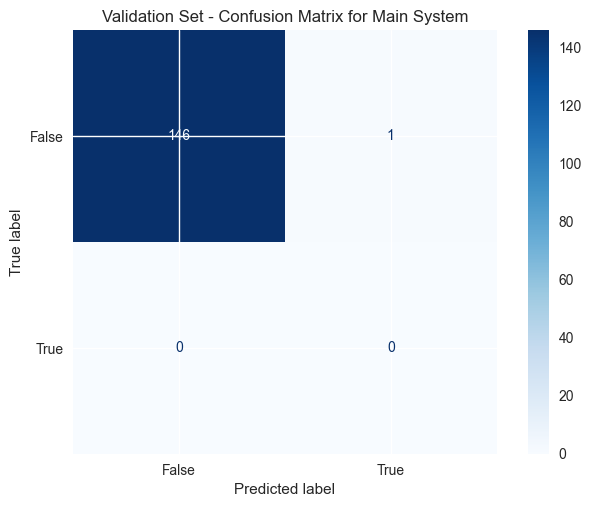

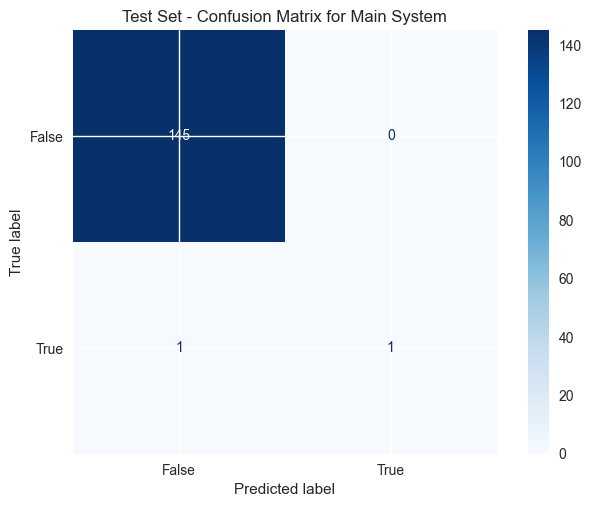

c:\Users\Marco Porce\Documents\GitHub\SelectedTopic\env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


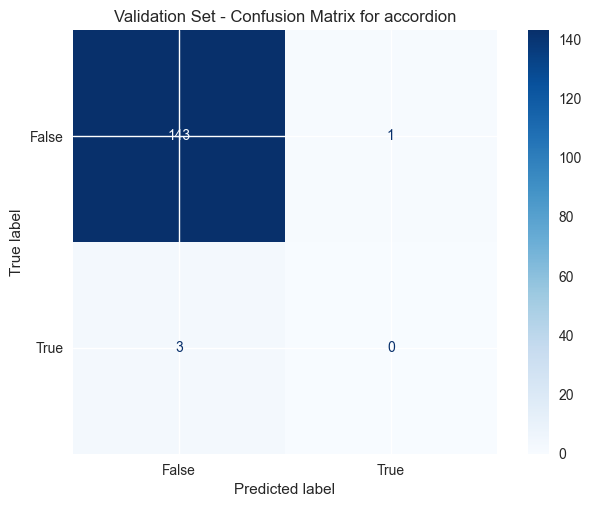

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

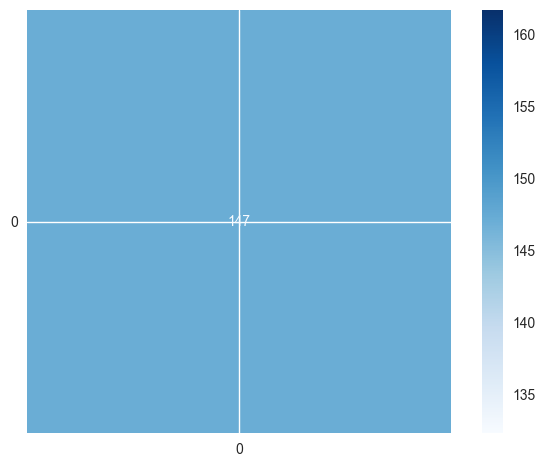

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Inverso della trasformazione dei label binari
y_val_pred = (modelCNN.predict(X_val) > 0.5).astype(int)
y_test_pred = (modelCNN.predict(X_test) > 0.5).astype(int)

# Trasformare i label binari in etichette originali
y_val_original = mlb.inverse_transform(y_val)
y_test_original = mlb.inverse_transform(y_test)
y_val_pred_original = mlb.inverse_transform(y_val_pred)
y_test_pred_original = mlb.inverse_transform(y_test_pred)

# Creare una matrice di confusione per ogni classe
for idx, class_name in enumerate(mlb.classes_):
    # Calcolare la matrice di confusione per la classe specifica
    cm_val = confusion_matrix(y_val[:, idx], y_val_pred[:, idx])
    cm_test = confusion_matrix(y_test[:, idx], y_test_pred[:, idx])

    # Visualizzare la matrice di confusione per la classe corrente
    disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["False", "True"])
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["False", "True"])

    # Plot per il validation set
    disp_val.plot(cmap='Blues')
    plt.title(f"Validation Set - Confusion Matrix for {class_name}")
    plt.show()

    # Plot per il test set
    disp_test.plot(cmap='Blues')
    plt.title(f"Test Set - Confusion Matrix for {class_name}")
    plt.show()


In [45]:
print(y_val_pred[6])

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_val_pred))